### Visualizing the filters of VGG16
VGG16 stands for Visual Geometry Group (Oxford). It was used to win the ILSVR (ImageNet) competition in 2014. It uses a gray image with noise to get activations using _gradient ascent_.
This code is taken from: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [1]:
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


In [6]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [4]:
model = vgg16.VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128
layer_name = 'block4_conv1'

In [12]:
# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
number_of_filters = layer_dict[layer_name].output.shape[3]
print(number_of_filters, "filters")

kept_filters = []
for filter_index in range(0, number_of_filters):
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        # print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

512 filters
Processing filter 0
Filter 0 processed in 4s
Processing filter 1
Filter 1 processed in 4s
Processing filter 2
Filter 2 processed in 4s
Processing filter 3
Filter 3 processed in 4s
Processing filter 4
Filter 4 processed in 4s
Processing filter 5
Filter 5 processed in 4s
Processing filter 6
Filter 6 processed in 4s
Processing filter 7
Filter 7 processed in 4s
Processing filter 8
Filter 8 processed in 4s
Processing filter 9
Filter 9 processed in 0s
Processing filter 10
Filter 10 processed in 4s
Processing filter 11
Filter 11 processed in 4s
Processing filter 12
Filter 12 processed in 4s
Processing filter 13
Filter 13 processed in 4s
Processing filter 14
Filter 14 processed in 4s
Processing filter 15
Filter 15 processed in 4s
Processing filter 16
Filter 16 processed in 4s
Processing filter 17
Filter 17 processed in 4s
Processing filter 18
Filter 18 processed in 4s
Processing filter 19
Filter 19 processed in 4s
Processing filter 20
Filter 20 processed in 4s
Processing filter 21


Filter 171 processed in 4s
Processing filter 172
Filter 172 processed in 4s
Processing filter 173
Filter 173 processed in 4s
Processing filter 174
Filter 174 processed in 4s
Processing filter 175
Filter 175 processed in 4s
Processing filter 176
Filter 176 processed in 4s
Processing filter 177
Filter 177 processed in 4s
Processing filter 178
Filter 178 processed in 4s
Processing filter 179
Filter 179 processed in 4s
Processing filter 180
Filter 180 processed in 4s
Processing filter 181
Filter 181 processed in 4s
Processing filter 182
Filter 182 processed in 4s
Processing filter 183
Filter 183 processed in 4s
Processing filter 184
Filter 184 processed in 4s
Processing filter 185
Filter 185 processed in 4s
Processing filter 186
Filter 186 processed in 4s
Processing filter 187
Filter 187 processed in 4s
Processing filter 188
Filter 188 processed in 4s
Processing filter 189
Filter 189 processed in 4s
Processing filter 190
Filter 190 processed in 4s
Processing filter 191
Filter 191 processed

Filter 339 processed in 4s
Processing filter 340
Filter 340 processed in 4s
Processing filter 341
Filter 341 processed in 4s
Processing filter 342
Filter 342 processed in 4s
Processing filter 343
Filter 343 processed in 5s
Processing filter 344
Filter 344 processed in 5s
Processing filter 345
Filter 345 processed in 4s
Processing filter 346
Filter 346 processed in 5s
Processing filter 347
Filter 347 processed in 4s
Processing filter 348
Filter 348 processed in 4s
Processing filter 349
Filter 349 processed in 4s
Processing filter 350
Filter 350 processed in 5s
Processing filter 351
Filter 351 processed in 5s
Processing filter 352
Filter 352 processed in 5s
Processing filter 353
Filter 353 processed in 5s
Processing filter 354
Filter 354 processed in 5s
Processing filter 355
Filter 355 processed in 5s
Processing filter 356
Filter 356 processed in 5s
Processing filter 357
Filter 357 processed in 5s
Processing filter 358
Filter 358 processed in 4s
Processing filter 359
Filter 359 processed

Filter 507 processed in 5s
Processing filter 508
Filter 508 processed in 5s
Processing filter 509
Filter 509 processed in 5s
Processing filter 510
Filter 510 processed in 5s
Processing filter 511
Filter 511 processed in 5s


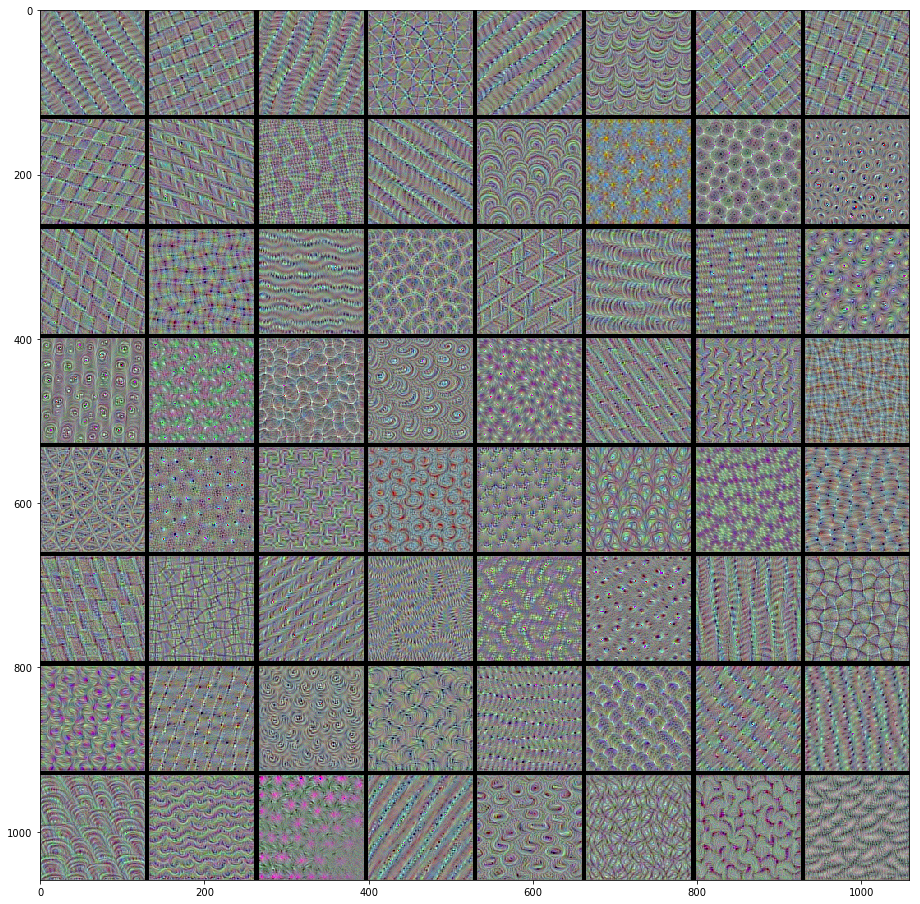

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(stitched_filters)